# Predicting Obesity with Support Vector Machines

https://github.com/rrazz247/obesity-SVM

### Problem Description

The goal of this project will be to predict obesity based on a series of 16 predictors, including gender, age, family history, water intake, family history, etc. I downloaded this dataset from kaggle, and it is originally part of the UCI machine learning repository:

https://www.kaggle.com/datasets/adeniranstephen/obesity-prediction-dataset

There are 2,111 rows and 17 columns, including the target variable `NObeyesdad`. This variable categorizes people into one of seven categories: Insufficient_Weight, Normal_Weight, Overweight_Level_I, Overweight_Level_II, Obesity_Type_I, Obesity_Type_II, or Obesity_Type_III. Therefore, this is a multiclass classification problem.

I plan to use support vector machines (SVM) to accomplish this task.

### Exploratory Data Analysis

First I will load the libraries and load in the dataset.

In [ ]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Load data

data = pd.read_csv('./data.csv')

There are 2,111 rows and 17 features (including the target). A description of each feature is given below:

In [86]:
print(data.shape)
data.head()

(2111, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Gender – Male or Female.

Age – The person’s age in years.

Height – Height in meters.

Weight – Weight in kilograms.

family_history_with_overweight – Whether the person has a family history of being overweight (yes/no).

FAVC – If the person frequently consumes high-calorie foods (yes/no).

FCVC – Frequency of vegetable consumption (scale from 1 to 3).

NCP – Number of main meals per day.

CAEC – Frequency of consuming food between meals (Never, Sometimes, Frequently, Always).

SMOKE – Whether the person smokes (yes/no).

CH2O – Daily water intake (scale from 1 to 3).

SCC – If the person monitors their calorie intake (yes/no).

FAF – Physical activity frequency (scale from 0 to 3).

TUE – Time spent using technology (scale from 0 to 3).

CALC – Frequency of alcohol consumption (Never, Sometimes, Frequently, Always).

MTRANS – Main mode of transportation (Automobile, Bike, Motorbike, Public Transportation, Walking).

NObeyesdad – Obesity level (Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II, Obesity Type III).

The below output shows that there are no null entries in this dataset, so no need to worry about missing values.

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   int64  
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

As a preliminary analysis, I will plot histograms of the numeric columns. Notably, this dataset comes from a fairly young group of people, where there are very few people over the age of 40.

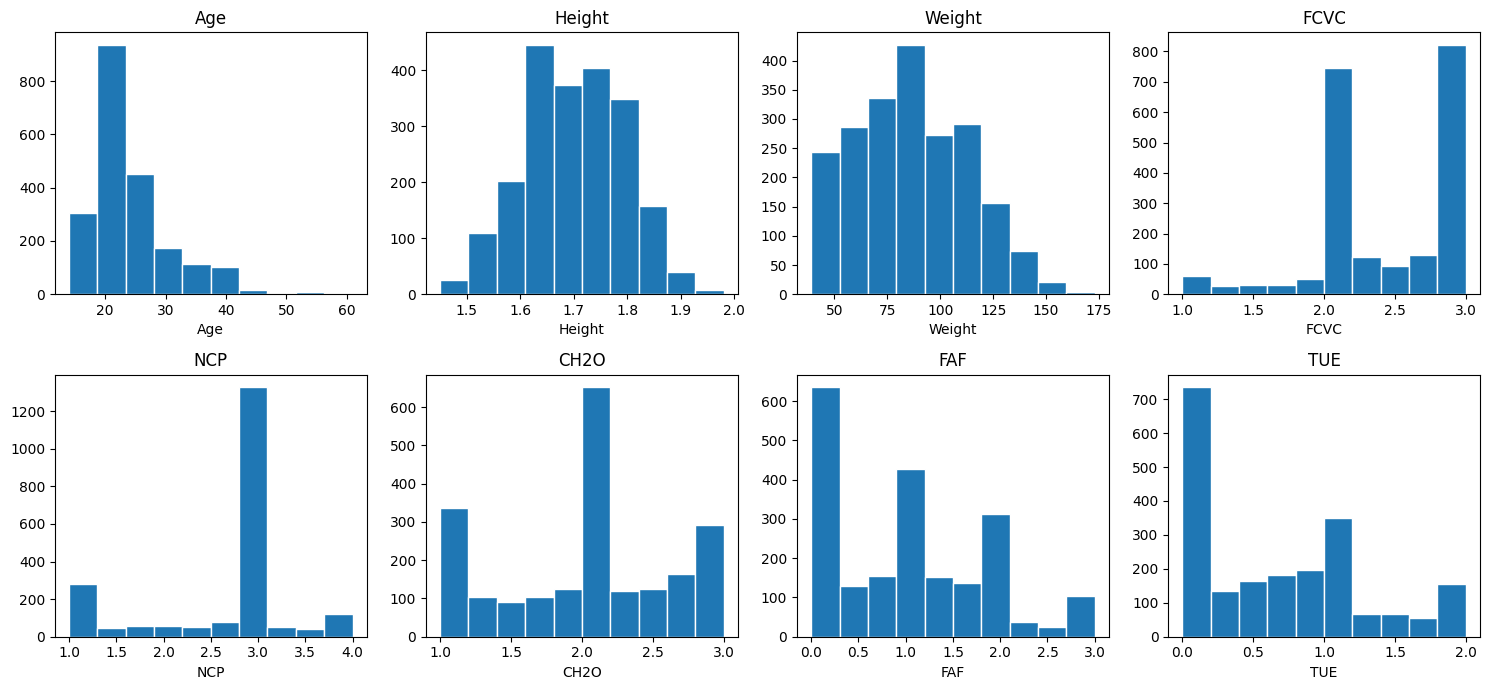

In [88]:
numeric_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

plt.figure(figsize=(15, 7))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 4, i) 
    plt.hist(data[col], edgecolor='white')
    plt.title(col) 
    plt.xlabel(col)

plt.tight_layout()
plt.show()


Below are bar plots for the categorical variables. Of note, the counts for the target variable `NObeyesdad` groupings are fairly even. This is convenient, as we do not need to worry about class imbalance.

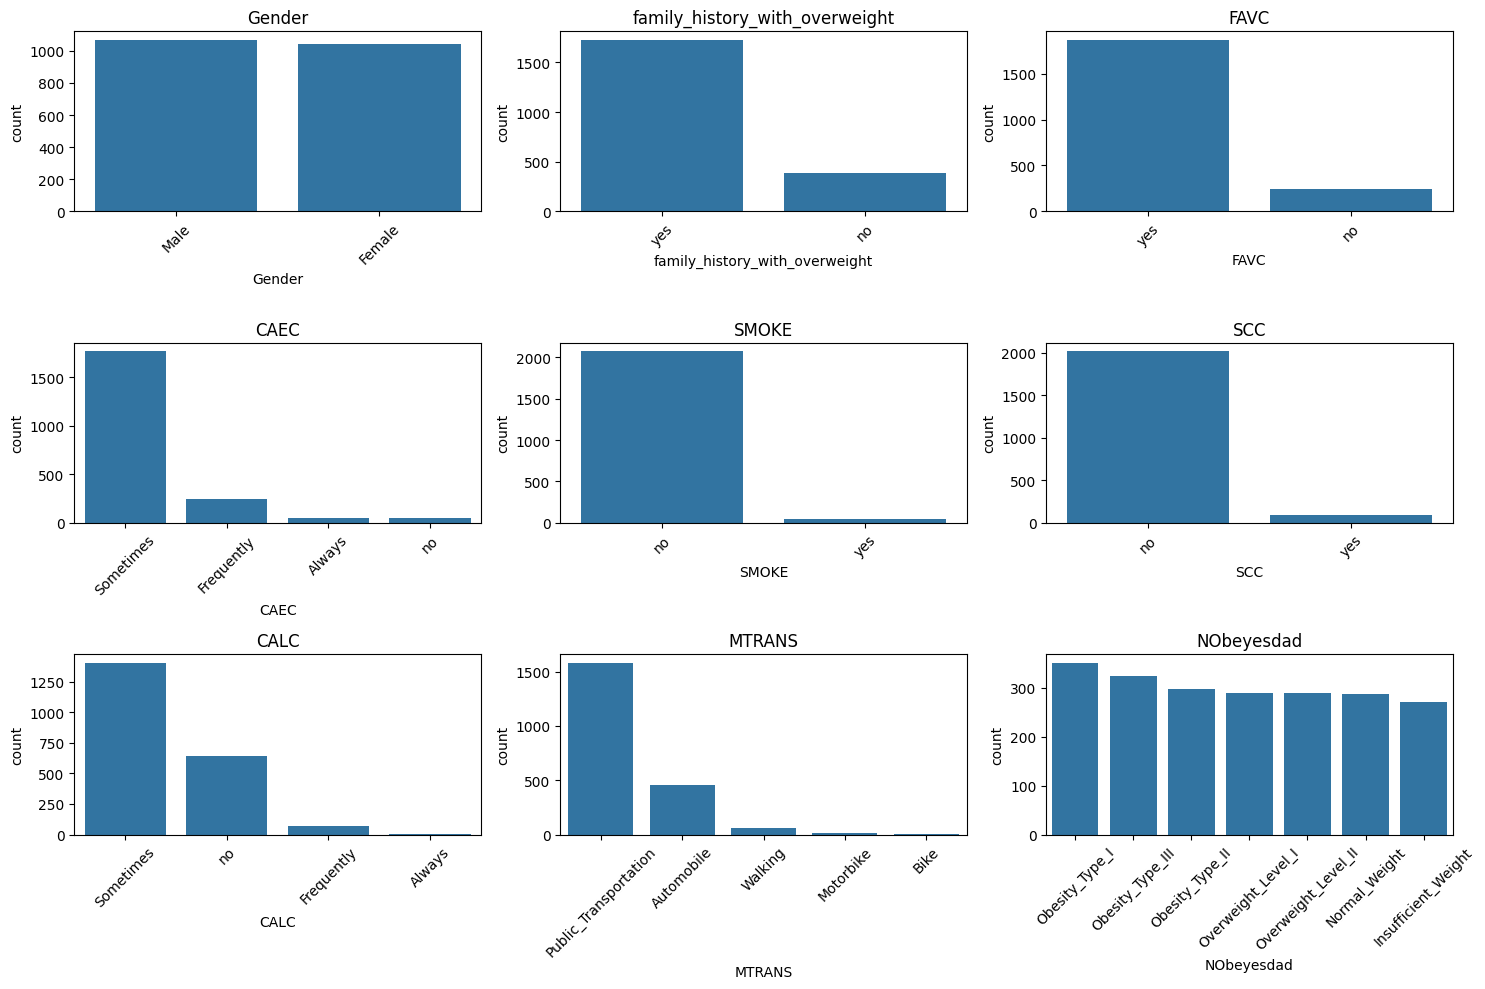

In [89]:
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=data[col], order=data[col].value_counts().index)
    plt.title(col)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

To get a better sense of the target variable groups, I plotted height and weight and colored the points by obesity group `NObeyesdad`. There are clear groups already seen here, though with some overlaps. Along with the other predictor variables, SVM should be able to segregate these groups well.

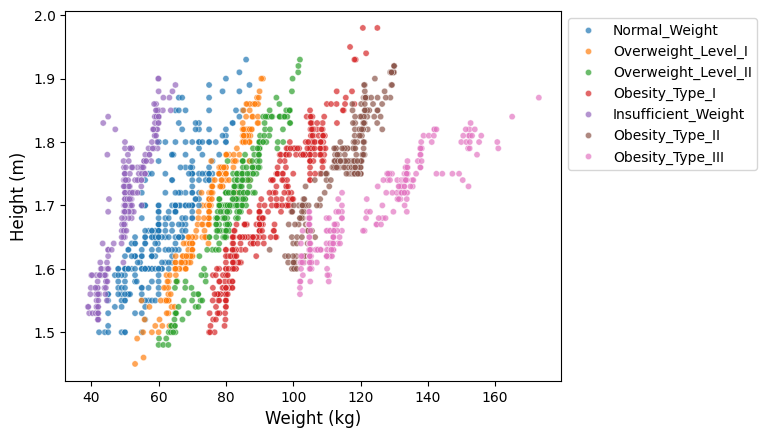

In [90]:
sns.scatterplot(x='Weight', y='Height', hue='NObeyesdad', data=data, s=20, alpha=0.7)

plt.xlabel('Weight (kg)', fontsize=12)
plt.ylabel('Height (m)', fontsize=12)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

### Analysis

Before training the SVM model, I will first process the data so that it is in a usable format. I applied label encoding for binary columns and created dummy variables for the multiclass columns.

In [ ]:
# Label encoder for binary columns

binary_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
label_encoder = LabelEncoder()
for col in binary_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Dummy variables for multiclass columns

multi_class_cols = ['CAEC', 'CALC', 'MTRANS']
data = pd.get_dummies(data, columns=multi_class_cols, drop_first=True)

# Target

data['NObeyesdad'] = label_encoder.fit_transform(data['NObeyesdad'])

In [92]:
data.head(10)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,...,CAEC_Frequently,CAEC_Sometimes,CAEC_no,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,21,1.62,64.0,1,0,2.0,3.0,0,2.0,...,False,True,False,False,False,True,False,False,True,False
1,0,21,1.52,56.0,1,0,3.0,3.0,1,3.0,...,False,True,False,False,True,False,False,False,True,False
2,1,23,1.80,77.0,1,0,2.0,3.0,0,2.0,...,False,True,False,True,False,False,False,False,True,False
3,1,27,1.80,87.0,0,0,3.0,3.0,0,2.0,...,False,True,False,True,False,False,False,False,False,True
4,1,22,1.78,89.8,0,0,2.0,1.0,0,2.0,...,False,True,False,False,True,False,False,False,True,False
5,1,29,1.62,53.0,0,1,2.0,3.0,0,2.0,...,False,True,False,False,True,False,False,False,False,False
6,0,23,1.50,55.0,1,1,3.0,3.0,0,2.0,...,False,True,False,False,True,False,False,True,False,False
7,1,22,1.64,53.0,0,0,2.0,3.0,0,2.0,...,False,True,False,False,True,False,False,False,True,False
8,1,24,1.78,64.0,1,1,3.0,3.0,0,2.0,...,False,True,False,True,False,False,False,False,True,False
9,1,22,1.72,68.0,1,1,2.0,3.0,0,2.0,...,False,True,False,False,False,True,False,False,True,False


In [ ]:
X = data.drop('NObeyesdad', axis=1) 
y = data['NObeyesdad'] 

Since SVM tries to create a decision boundary between points, it is generally good practice to standardize the numeric variables. Below I standardize the numeric variables using the `StandardScaler()` function.

In [ ]:
numeric_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
categorical_cols = [col for col in X.columns if col not in numeric_cols]

# Standardize numeric columns

scaler = StandardScaler()
X_scaled_numeric = scaler.fit_transform(X[numeric_cols])
X_scaled = np.hstack((X_scaled_numeric, X[categorical_cols].values))
X_scaled_df = pd.concat([pd.DataFrame(X_scaled_numeric, columns=numeric_cols), X[categorical_cols].reset_index(drop=True)], axis=1)

print(X_scaled_df.head())

        Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
0 -0.521741 -0.874380 -0.862558 -0.784810  0.404102 -0.013141 -1.188028   
1 -0.521741 -1.945660 -1.168077  1.088307  0.404102  1.618701  2.339676   
2 -0.207057  1.053924 -0.366089 -0.784810  0.404102 -0.013141  1.163774   
3  0.422312  1.053924  0.015809  1.088307  0.404102 -0.013141  1.163774   
4 -0.364399  0.839668  0.122741 -0.784810 -2.166941 -0.013141 -1.188028   

        TUE  Gender  family_history_with_overweight  ...  CAEC_Frequently  \
0  0.562005       0                               1  ...            False   
1 -1.080619       0                               1  ...            False   
2  0.562005       1                               1  ...            False   
3 -1.080619       1                               0  ...            False   
4 -1.080619       1                               0  ...            False   

   CAEC_Sometimes  CAEC_no  CALC_Frequently  CALC_Sometimes  CALC_no  \
0            T

Next, I split the data into train and test sets at a 80/20 ratio.

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=546)

Now that the data is cleaned and processed, it is good to go for fitting the SVM model. For this first pass, I used a linear kernel and the default regularization parameter `C` = 1.

In [96]:
svm_model = SVC(kernel='linear', random_state=123) 
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=123)

Below is the accuracy of this model along with a confusion matrix. The accuracy is high at 0.9409. The confusion matrix shows that there are very few miscategorizations, but what is surpising is that there are 7 cases where a `Normal_Weight` person was predicted as `Overweight_Level_I`. There is a big difference between those two categories, so the fact that there are so many such miscategorizations is interesting.

In [ ]:
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.9408983451536643


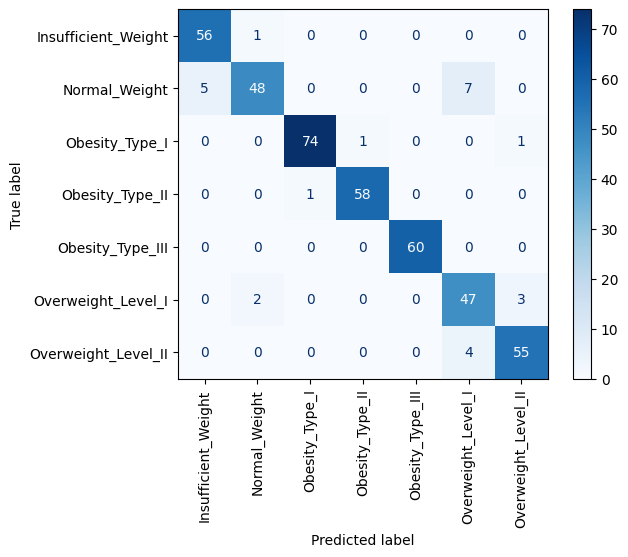

In [98]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

disp.plot(cmap='Blues', values_format='d') 
plt.xticks(rotation=90)
plt.show()

### Results

Now that an initial model has been trained, I will proceed with hyperparameter tuning. I am interested in tuning the `kernel` and regularization parameter `C`. A linear kernel is simpler and is robust against overfitting, while a radial kernel can fit more complex relationships, but is more prone to overfitting. Polynomial kernel strikes a balance between these two. The regularization parameter `C` controls how smooth or rough the decision boundary is. A higher value will fit the patterns in the data closer, but be more prone to overfitting. I aribtrarily picked three values to try: 0.7, 1, and 1.3.

In [99]:
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.7, 1, 1.3]
}

svm_model = SVC(random_state=123)

grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    cv=5, 
    scoring='accuracy', 
    verbose=1,  
    n_jobs=-1 
)

In [105]:
# Grid search

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=SVC(random_state=123), n_jobs=-1,
             param_grid={'C': [0.7, 1, 1.3],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=1)

Interestingly, the original model with C = 1 and linear kernel turned out to be the best performing model with an accuracy of 0.94089.

In [106]:
# Best hyperparameters
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_best)
print(accuracy)


{'C': 1, 'kernel': 'linear'}
0.9408983451536643


Below is a summary of the different hyperparameter combinations and the mean accuracy from the five-fold cross validation that was performed during tuning. While all combinations yielded reasonably high accuracies, the linear kernel clearly outperformed the others.

In [ ]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df[['param_kernel', 'param_C', 'mean_test_score']]

results_df.rename(columns={
    'param_kernel': 'Kernel',
    'param_C': 'C',
    'mean_test_score': 'Accuracy'
}, inplace=True)

results_df = results_df.sort_values(by='Accuracy', ascending=False)
print(results_df)

   Kernel    C  Accuracy
3  linear  1.0  0.948456
6  linear  1.3  0.947276
0  linear  0.7  0.944312
7     rbf  1.3  0.924185
4     rbf  1.0  0.915885
8    poly  1.3  0.912921
5    poly  1.0  0.908777
2    poly  0.7  0.902262
1     rbf  0.7  0.901665


### Conclusion

The goal of this project was to solve a multiclass categorization problem, where obesity type was predicted from a series of features. I was able to successfully accomplish this task using support vector machines, where the best model yielded a fairly high accuracy of 0.94089. From the hyperparameter tuning procedure, I found that the best combination of hyperparameters was to the linear kernel and regularization parameter C = 1. Generally, the linear kernels outperformed the other kernels. This is likely because there are no complex relationships in the data that would necessitate nonlinear kernels. So the radial and polynomial kernels likely overfit the training data and had reduced accuracy as a result.